<h1><center> Predicting Used Cars' Prices (Part I) </center></h1>

<img src=car.jpg >


This is my third quarantine project. It falls under the Prediction Modelling Projects. I got inspired by [Terence Shin](https://towardsdatascience.com/@terenceshin)'s [14 Data Science Projects to do During Your 14 Day Quarantine](https://towardsdatascience.com/14-data-science-projects-to-do-during-your-14-day-quarantine-8bd60d1e55e1) article and started working on some of his project ideas in more detail. 

I obtained the dataset from Kaggle. It is scraped from Craigslist, providing information about car sales like price, maker, model, condition, odometer, etc. (It is updated every few months. I am using Version 5.) The dataset consists of 539759 observations. Because the data size is around 1.4 GB, I am not providing it here, but you can freely download it from [here](https://www.kaggle.com/austinreese/craigslist-carstrucks-data). (You may required to log in)

I first performed an exploratory data analysis to better understand the data set and then build four different machine learning model to predict the used car prices. I compare the models based on their mean absolute error (MAE) score and list them below along with the time (in seconds) it took to train them and used them to predict my test cases. 

| Model                   |   MAE     | Train Time | Pred. Time |
| :----------------------:|:---------:|-----------:|------------|
| XGB Regressor           | 5317.518  |      7.79  |     0.28   |
| Linear Regression       | 5428.409  |     25.03  |     0.00   |
| Random Forest Regressor | 5606.673  |   3635.40  |     3.36   |
| K-Neighbors Classifier  | 7690.753  |      0.05  |   734.81   |

Even though the performance of XG Boost, Linear, and Random Forest Regressions perform similarly, XG Boost is slightly better and the time it requires to train and predict is the smallest. However, below, you can see the difference between the predicted and the real prices. It seems like XG Boost mostly predicting the average as predicted price. In Part II, I will try to optimize my model, improve my features, hence, obtain better results.

<img src=xgb_real_vs_predicted.PNG width=500>

Following is the structure of the notebook, you can simply jump to the section by clicking on its name. 

1. [Data Overview and Data Cleaning](#data_cleaning_link)
    1. [Outliers](#outliers_link)
2. [EDA Analysis](#eda_link)
3. [Machine Learning](#machine_learning_link)
    1. [Preprocessing Data](#preprocessing_data_link)
        
    2. [Modeling](#modeling_link)
        1. [Random Forest Regressor](#forest_model_link)
        2. [Linear Regression](#lin_model_link)
        3. [kNN Classifier](#knn_model_link)
        4. [XG Boost](#xgb_model_link)
    3. [Model Comparison](#model_comparison)
4. [Concluding Remarks](#concluding_remarks_link)
    1. [Conclusion](#conclusion_link)
    2. [Go to Part II](link_to_part2)

<a id="data_cleaning_link"></a>
# 1. Data Overview and Data Cleaning

In [34]:
# Import the packages we will need
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import warnings

In [2]:
df_raw = pd.read_csv("vehicles.csv")

In [3]:
df_raw.head()

id                                                url      region  \
0  7088746062  https://greensboro.craigslist.org/ctd/d/cary-2...  greensboro   
1  7088745301  https://greensboro.craigslist.org/ctd/d/bmw-3-...  greensboro   
2  7088744126  https://greensboro.craigslist.org/cto/d/greens...  greensboro   
3  7088743681  https://greensboro.craigslist.org/ctd/d/cary-2...  greensboro   
4  7074612539  https://lincoln.craigslist.org/ctd/d/gretna-20...     lincoln   

                          region_url  price    year manufacturer  \
0  https://greensboro.craigslist.org  10299  2012.0        acura   
1  https://greensboro.craigslist.org      0  2011.0          bmw   
2  https://greensboro.craigslist.org   9500  2011.0       jaguar   
3  https://greensboro.craigslist.org   3995  2004.0        honda   
4     https://lincoln.craigslist.org  41988  2016.0    chevrolet   

               model  condition    cylinders  ... drive  size         type  \
0                 tl        NaN          NaN  ...   NaN   NaN        other   
1                335        NaN  6 cylinders  ...   rwd   NaN  convertible   
2                 xf  excellent          NaN  ...   NaN   NaN          NaN   
3            element        NaN          NaN  ...   fwd   NaN          SUV   
4  silverado k2500hd        NaN          NaN  ...   NaN   NaN          NaN   

  paint_color                                          image_url  \
0        blue  https://images.craigslist.org/01414_3LIXs9EO33...   
1        blue  https://images.craigslist.org/00S0S_1kTatLGLxB...   
2        blue  https://images.craigslist.org/00505_f22HGItCRp...   
3      orange  https://images.craigslist.org/00E0E_eAUnhFF86M...   
4         NaN  https://images.craigslist.org/00S0S_8msT7RQquO...   

                                         description county state      lat  \
0  2012 Acura TL Base 4dr Sedan     Offered by: B...    NaN    nc  35.7636   
1  BMW 3 Series 335i Convertible Navigation Dakot...    NaN    nc      NaN   
2  2011 jaguar XF premium - estate sale. Retired ...    NaN    nc  36.1032   
3  2004 Honda Element LX 4dr SUV     Offered by: ...    NaN    nc  35.7636   
4  Shop Indoors, Heated Showroom!!!www.gretnaauto...    NaN    ne  41.1345   

      long  
0 -78.7443  
1      NaN  
2 -79.8794  
3 -78.7443  
4 -96.2458  

[5 rows x 25 columns]

In [4]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 539759 entries, 0 to 539758
Data columns (total 25 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   id            539759 non-null  int64  
 1   url           539759 non-null  object 
 2   region        539759 non-null  object 
 3   region_url    539759 non-null  object 
 4   price         539759 non-null  int64  
 5   year          538772 non-null  float64
 6   manufacturer  516175 non-null  object 
 7   model         531746 non-null  object 
 8   condition     303707 non-null  object 
 9   cylinders     321264 non-null  object 
 10  fuel          536366 non-null  object 
 11  odometer      440783 non-null  float64
 12  title_status  536819 non-null  object 
 13  transmission  535786 non-null  object 
 14  vin           315349 non-null  object 
 15  drive         383987 non-null  object 
 16  size          168550 non-null  object 
 17  type          392290 non-null  object 
 18  pain

<a id="outliers_link"></a>
## 1.A. Outliers

Let's create a function, remOutlier(), that will take a dataframe, df,  and column name, col, as input and remove the observations that have outliers in the col variable. 

In removing the outliers, I use midspread rule, also called as IQR. According to IQR, a data is outlier if it is more than 1.5 interquartile ranges (IQRs) below the first quartile or above the third quartile.

In [5]:
def removeOutlier(data, col):    
    quant1 = data[col].quantile(0.25)
    quant3 = data[col].quantile(0.75)
    iqr = quant3 - quant1
    filtered = data.loc[(data[col] >= quant1 - 1.5*iqr) & (data[col] <= quant1 + 1.5*iqr)]
    
    return filtered

In [6]:
from matplotlib import pyplot as plt

I will be using the variables 
	- county, region, state as different values of the market.  
	- year, manufacturer, manufacturer, model, and odometer  to define a car
	- title_status, transmission, type, condition, description, paint_color

I will be excluding the following variables:
	- vin : it is a unique number for each car.
	- url, region_url, image_url : unique addresses that are irrelevant with the car
	- cylinders, fuel, drive, size : These are not the driving futures in determining the price of a car even though they do play some roles
	- county, lat, long : Even though these variables give information about the market of a used car, I am planning to use region/state for the market

In [7]:
cols = ["region", "state", "year", "manufacturer", "model", "odometer", "title_status", "transmission", "type", "condition", "description", "paint_color", "price" ]
df_all = df_raw.copy()[cols]

# Some cars listed here are new, since I am interested in used cars, I will drop the new ones
df_used = df_all.loc[df_all.condition != "new"]

In [8]:
df_used.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 538148 entries, 0 to 539758
Data columns (total 13 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   region        538148 non-null  object 
 1   state         538148 non-null  object 
 2   year          537161 non-null  float64
 3   manufacturer  515003 non-null  object 
 4   model         530173 non-null  object 
 5   odometer      439861 non-null  float64
 6   title_status  535208 non-null  object 
 7   transmission  534177 non-null  object 
 8   type          391183 non-null  object 
 9   condition     302096 non-null  object 
 10  description   538127 non-null  object 
 11  paint_color   364271 non-null  object 
 12  price         538148 non-null  int64  
dtypes: float64(2), int64(1), object(10)
memory usage: 57.5+ MB


In [9]:
df_used.describe()

year      odometer         price
count  537161.000000  4.398610e+05  5.381480e+05
mean     2009.816673  1.009418e+05  1.959482e+05
std         9.150465  1.768472e+05  2.211555e+07
min         0.000000  0.000000e+00  0.000000e+00
25%      2007.000000  4.722600e+04  4.400000e+03
50%      2012.000000  9.343000e+04  9.500000e+03
75%      2015.000000  1.378490e+05  1.790000e+04
max      2021.000000  6.480922e+07  4.294967e+09

Let's remove the outliers using the removeOutliers() function we created above. 

In [10]:
df_used_pr = removeOutlier(df_used, "price")
df_used_od = removeOutlier(df_used_pr, "odometer")

cars = df_used_od.copy()

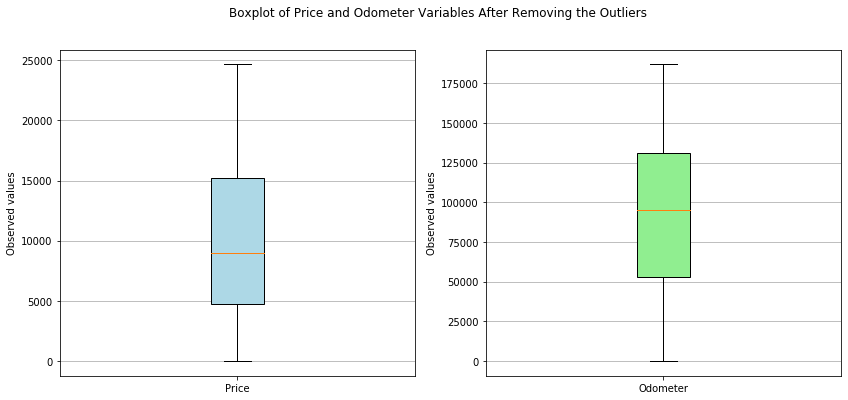

In [11]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(14, 6))
# First subplot
subplot1 = ax1.boxplot(cars.price, 
                       patch_artist=True,
                       labels= ["Price"])
for patch in subplot1["boxes"]:
    patch.set_facecolor("lightblue")
# second subplot    
subplot2 = ax2.boxplot(cars.odometer,
                       patch_artist=True,
                      labels = ["Odometer"])
for patch in subplot2["boxes"]:
    patch.set_facecolor("lightgreen")

# axes labels 
for ax in [ax1, ax2]:
    ax.yaxis.grid(True)
    ax.set_ylabel('Observed values')
# Figure title    
fig.suptitle("Boxplot of Price and Odometer Variables After Removing the Outliers")
plt.show()

<a id = "eda_link"></a>
## 2. EDA Analysis
To see the correlation between these variables, let's create a heatmap that represents the correlation matrix. 

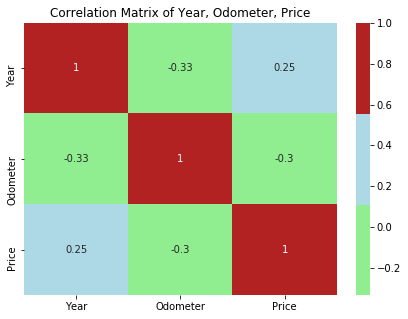

In [12]:
corr_mat = cars.corr() 
colors = ["lightgreen", "lightblue", "firebrick"]

# plot the heatmap
fig = plt.figure(figsize=(7,5))
sns.heatmap(corr_mat,annot=True, 
            cmap = colors,
           xticklabels = [var.capitalize() for var in corr_mat.columns],
           yticklabels = [var.capitalize() for var in corr_mat.columns]
           )
plt.title("Correlation Matrix of {}".format(", ".join([var.capitalize() for var in corr_mat.columns])))
plt.show()

Observe that the correlation between odometer and price is negative while it positive for year and price as expected. 

Now let us see the price dispersion for different types of cars. 

<Figure size 432x288 with 0 Axes>

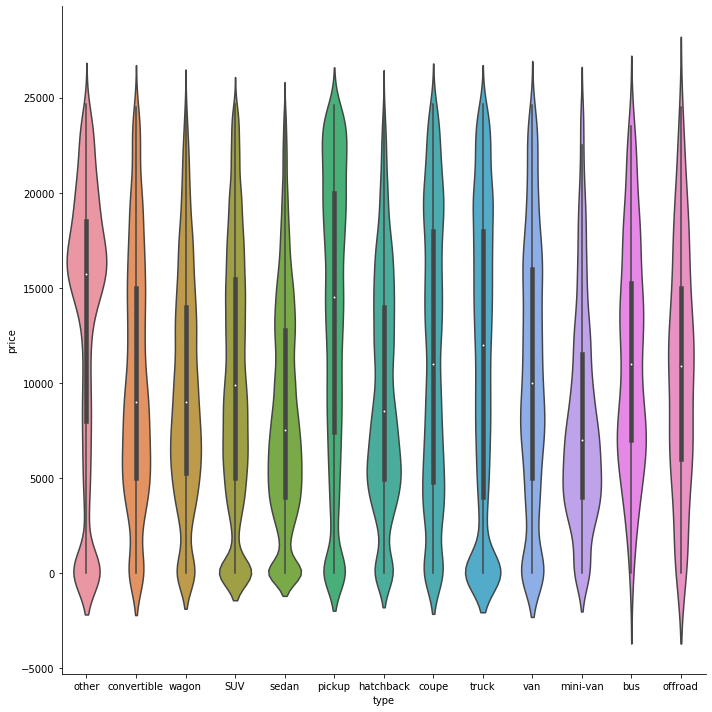

In [13]:
fig = plt.figure()
g = sns.catplot(data = cars, 
                y="price",
                x = "type",
                kind = "violin",
                height=10, aspect=1
               )
plt.show()


As seen above in the violin plot pickups seem more expensive on average. Moreover, mini-van prices are less dispersed. This can be due that there is less variety in mini-van class. It is worth investigating. 

The market size of the manufacturers as well as the market segmentation based on types 

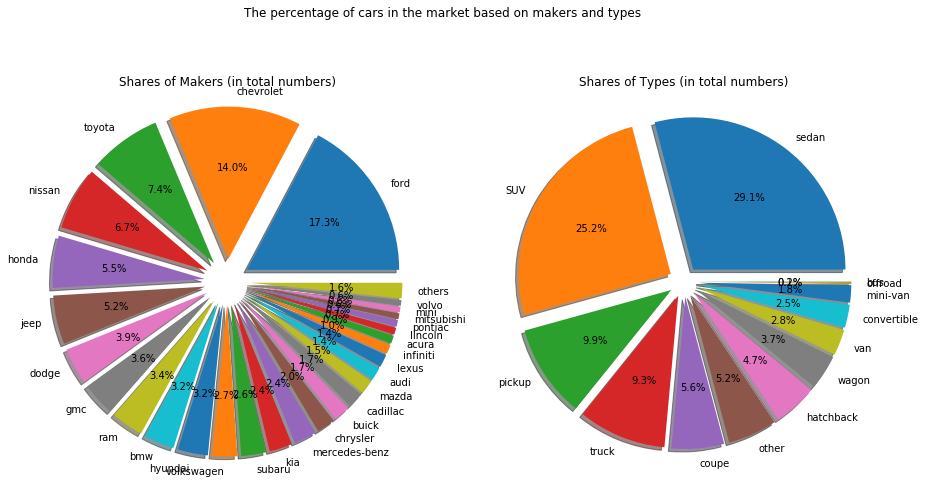

In [14]:
#df_pie = cars.copy()["type", "manufacturer"]

maker_dist = cars.manufacturer.value_counts() / cars.manufacturer.value_counts().sum()
mask = maker_dist >= 0.006
makers_included = maker_dist[mask]
other_share = 1 - makers_included.sum()
others = pd.Series([other_share], index=["others"])
makers_pie = makers_included.append(others)
makers = makers_pie.index


type_dist = cars.type.value_counts() / cars.type.value_counts().sum()
types = type_dist.index

fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15, 8))
# First subplot
subplot1 = ax1.pie(makers_pie, labels= makers, autopct='%1.1f%%', explode =len(makers)*[0.15], shadow=True)
ax1.set_title("Shares of Makers (in total numbers)")

# second subplot    
subplot2 = ax2.pie(type_dist, labels= types, autopct='%1.1f%%', explode =len(types)*[0.1],shadow=True)
ax2.set_title("Shares of Types (in total numbers)")


fig.suptitle("The percentage of cars in the market based on makers and types")
plt.show()


However, as we very well know some manufacturers make only some types of cars. When we consider the four largest type market and the average price distribution in that category, we obtain the following figure. 

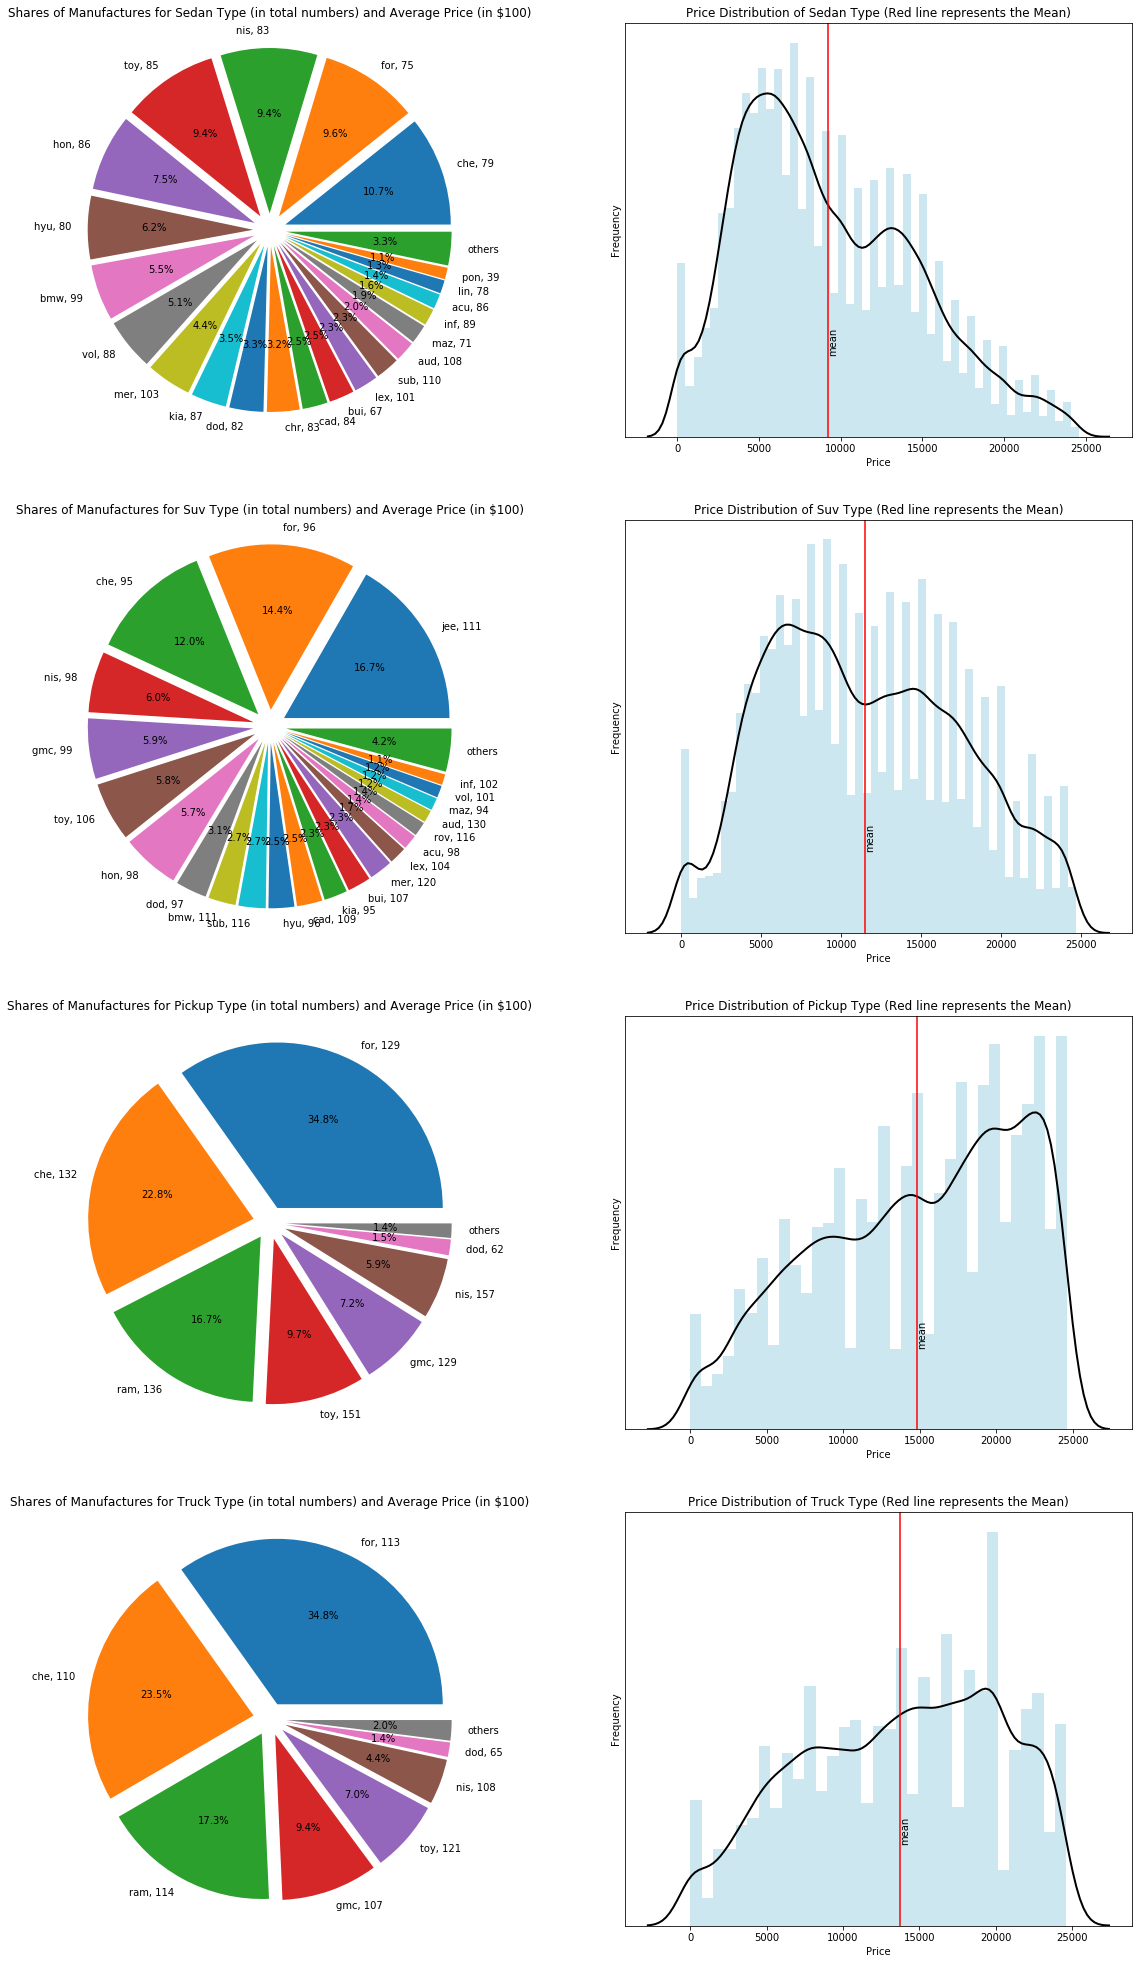

In [15]:
df_type = cars.copy()[["manufacturer", "type", "price"]]

fig, axs = plt.subplots(nrows=4, ncols=2, figsize=(20,35))
type_num = 0
for row in axs:
# Left Figure : Pie Chart
        ax1 = row[0]
        car_type = types[type_num] 
        type_cars = df_type.loc[df_type.type == car_type] 
        maker_dist = type_cars.manufacturer.value_counts() / type_cars.manufacturer.value_counts().sum()
        
        # Pick the makers who manufactured at least 1% of all the cars in car_type. 
        mask = maker_dist >= 0.01
        makers_included = maker_dist[mask]
        # add all the exluded ones and create one big label for all of them, i.e others
        other_share = 1 - makers_included.sum()
        others = pd.Series([other_share], index=["others"])
        makers_pie = makers_included.append(others)
        makers = makers_pie.index  
        
        # create the labels as the first three letters of the makers along with average price of the cars in the category 
        avg_price = type_cars.groupby("manufacturer").mean()
        labels = [maker[:3] + ", " + str( int(avg_price.loc[maker].price // 100)) for maker in makers if maker != "others"]
        labels.append("others")  
                
        ax1.pie(makers_pie, 
                labels= labels, 
                autopct='%1.1f%%', 
                explode =len(makers)*[0.1], 
                shadow=False)
        ax1.set_title("Shares of Manufactures for {} Type (in total numbers) and Average Price (in $100)".format(car_type.capitalize()))               

        type_num +=1
# Right Figure : Distribution Plot         
        ax2 = row[1]
        sns.distplot(type_cars.price.loc[type_cars.price > 0], 
                     kde_kws ={"color": "k", "lw": 2, "alpha" : 1},
                     hist_kws={"color": "lightblue", "alpha": 0.6}, 
                     ax=ax2)
        
        # show the mean
        x = type_cars.price.loc[type_cars.price > 0].mean()        
        ax2.axvline(x, color="r")
        
        #Since the limit of y axis changes and they are so small numbers, tranform y limit to [0,1]
        trans = ax2.get_xaxis_transform()
        ax2.text(x,0.2,"mean" , rotation=90, transform = trans)
        #ax2.text(x,0.000001,"mean",rotation=90)
        
        ax2.set_title("Price Distribution of {} Type (Red line represents the Mean)".format(car_type.capitalize()))
        ax2.set_xlabel("Price")
        ax2.set_ylabel("Frequency")
        # No need to show the frequency values since they do not make sense in a pdf
        plt.setp(ax2.get_yticklabels(), visible=False)
        ax2.tick_params(axis= "y", which='both', length=0)
        
               
        
plt.show()

Exp: The numbers next to the manufacturer names in the pie chart represnt the average price of car of the manufacturer in that market (in $100) . 

Some Remarks: 
- The largest number of cars are Sedan, SUV, Pickup, and Truck types. 
- Sedan and SUV market seems relatively competitive whereas we observe a more oligopolistic structure in Pickup and Truck markets (in terms of total numbers of cars)
- SUV and Pickup cars are more expensive on average than Sedan and SUV cars. 
- Graphically, we do not observe a high (negative or positive) correlation between average price and the number of cars a manufacturer makes. 

Using the average odometer of a car let's see which states have higher averages. Assuming that on average the cars mostly used within the same state, we can use the following figure to conclude which states are exposed to higher level of carbon emmisions. 

In [16]:
# for this figure i use pltly.express library
import plotly.express as px
from datetime import datetime

cars_state = cars.copy()[["price", "state", "odometer", "year"]]
cars_state["age"] = datetime.now().year - cars_state.year
cars_state = cars_state.loc[cars_state.age < datetime.now().year]

choropleth_state = cars_state.groupby("state").mean().reset_index()
choropleth_state.state = choropleth_state.apply(lambda row: row.state.upper(), axis=1)

for var in ("price", "odometer", "age"):

    fig = px.choropleth(choropleth_state, 
                        locations="state",
                        locationmode = "USA-states",
                        color= var,
                        hover_name="state",
                        scope="usa",
                        color_continuous_scale="thermal",
                        labels={var: var.capitalize()}
                       )

    fig.update_layout(
        title_text = "Average Used Car {} by State".format(var.capitalize())
    )
    fig.show()

## Some Observations:

    - The least used and the most expensive cars ara in Alaska. This could be because 
        (i) the price makes it less use
        (ii) people do not rely on cars as much other states, maybe due to public transportation, the area of the populated part of the state
        (iii) Due to lack of interstate travel the average odometer is low
    - In Wyoming, the cars have high milages on average and more expensive, interestingly. 
    - The neihboring states LA and GA has similar average odometer, however, average price change dramatically. 
    - The opposite is true for IL and MO.
    - And more.. 

Of course, these are only a result of comparisons of the mean values. For a detailed investigation, we need to look into the distributions withing the states as well as the sales tax rates for each state. 


In [17]:
# If there is an observation that is missing the price value, we drop that observation
cols = ['price', 'state', 'year', 'manufacturer', 'model', 'odometer', 'title_status', 'transmission', 'type', 'condition']
X_df = cars.copy()[cols].dropna(subset=["price"]).reset_index(drop=True)
X_all = X_df.loc[X_df.price > 0]

<a id="machine_learning_link"></a>
# 3. Machine Learning

<a id ="preprocessing_data_link"></a>
## 3.A. Preprocessing Data

In [18]:
# Before the preprocessing step, I will divide my data into training and validation sets

from sklearn.model_selection import train_test_split
import time

y = X_all.price
X = X_all.drop("price", axis=1)

X_train_raw, X_valid_raw, y_train, y_valid = train_test_split(X, y, test_size=0.3)

In [19]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer 
from sklearn.preprocessing import OneHotEncoder


numerical_cols   = [col for col in X.columns if X[col].dtype in ["int64", "float"]]
categorical_cols = [col for col in X.columns if X[col].dtype == "object" ] 

# Preprocessing Numerical data: impute the missing values with the mean and scale the data
numeric_transformer = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy = "mean")),
    ("scaler", StandardScaler())
])
                    

# Preprocessing Categorical data: impute the missing values with the most frequent one and onehot encode the categories
categorical_transformer = Pipeline(steps=[
        ("imputer", SimpleImputer(strategy="most_frequent")),
        ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ])

# Combine the two type of column preprocessors
preprocessor = ColumnTransformer(
        transformers=[
                ("num", numeric_transformer, numerical_cols),
                ("cat", categorical_transformer, categorical_cols)
                ])


Preprocess will take so long time due to the size of the data and the high number of categories in categorical variables. Therefore, I will do this once and save the sparsematrices. However, next time I run this code I may need a different train test split, hence, I will ask the user if they want to re-preprocess the data. 

In [20]:
process_input = input("Do you want to use the already preprocessed data? (y, n) \nIf you choose no (n) the data will be re-preprocess and it takes so loong.")
import scipy.sparse

if process_input == "n":
    # use the raw train data to fit then transform both train and valid data
    X_train = preprocessor.fit_transform(X_train_raw)
    X_valid = preprocessor.transform(X_valid_raw)
    
    # Now save them:
    scipy.sparse.save_npz('X_train.npz', X_train)
    scipy.sparse.save_npz('X_valid.npz', X_valid)

else:    
    X_train = scipy.sparse.load_npz('X_train.npz')
    X_valid = scipy.sparse.load_npz('X_valid.npz')

print()    

Do you want to use the already preprocessed data? (y, n) 
If you choose no (n) the data will be re-preprocess and it takes so loong.y



<a id ="modeling_link"></a>
## 3.B. Modeling

At this stage we are done with preprocessing. Now, we combine preprocessing with our selection of models using a pipeline with the default hyper-parameters (unless n_jobs is an available option) and compare them based on mean absolute error. 
    1. Random Forest Regressor
    2. Linear Regression
    3. kNN Classifier
    4. XG Boost    

In [21]:
# import the necessary metrics to evaluate and compare our models' predicition power
from sklearn.metrics import mean_absolute_error
from time import time

<a id ="forest_model_link"></a>
### 3.B.a. Random Forest Regressor

In [22]:
from sklearn.ensemble import RandomForestRegressor
warnings.filterwarnings("ignore")

# Initiate the model pipeline using the default hyper-parameters
forest_model = RandomForestRegressor(n_estimators = 100, verbose= 3, n_jobs=-1)

# fit data to the model
start_fit = time()
forest_model.fit(X_train, y_train)
end_fit = time()

start_pred = time()
forest_model_preds = forest_model.predict(X_valid)
end_pred = time()

forest_model_score = mean_absolute_error(y_valid, forest_model_preds)
forest_model_fit_time = end_fit - start_fit
forest_model_pred_time = end_pred - start_pred

building tree 1 of 100building tree 2 of 100
building tree 3 of 100
building tree 4 of 100
building tree 5 of 100

building tree 6 of 100
building tree 7 of 100
building tree 8 of 100


[Parallel(n_jobs=-1)]: Using backend ThreadingBackend with 8 concurrent workers.


building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100


[Parallel(n_jobs=-1)]: Done  16 tasks      | elapsed: 10.2min


building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100
building tree 45 of 100
building tree 46 of 100
building tree 47 of 100
building tree 48 of 100
building tree 49 of 100
building tree 50 of 100
building tree 51 of 100
building tree 52 of 100
building tree 53 of 100
building tree 54 of 100
building tree 55 of 100
building tree 56 of 100
building tree 57 of 100
building tree 58 of 100
building tree 59 of 100
building tree 60 of 100
building tree 61 of 100
building tree 62 of 100
building tree 63 of 100
building tree 64 of 100
building tree 65

[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 60.6min finished
[Parallel(n_jobs=8)]: Using backend ThreadingBackend with 8 concurrent workers.
[Parallel(n_jobs=8)]: Done  16 tasks      | elapsed:    0.4s
[Parallel(n_jobs=8)]: Done 100 out of 100 | elapsed:    3.2s finished


In [23]:
forest_summary = {
"Model Name" : "Random Forest",
"Mean Absolute Error" : round(forest_model_score,2),
"Model Training Time" : round(forest_model_fit_time, 2),
"Model Prediction Time" : round(forest_model_pred_time, 2)
}

for key in forest_summary.keys():
    print(key, ": ", str(forest_summary[key]))

Model Name :  Random Forest
Mean Absolute Error :  5606.67
Model Training Time :  3635.4
Model Prediction Time :  3.36


<a id ="lin_model_link"></a>
### 3.B.b. Linear Regression

In [24]:
from sklearn.linear_model import LinearRegression

# Initiate the svm model pipeline with the default parameters
lin_model = LinearRegression(n_jobs=-1)

# fit data to the model
start_fit = time()
lin_model.fit(X_train, y_train)
end_fit = time()

start_pred = time()
lin_model_preds = lin_model.predict(X_valid)
end_pred = time()

lin_model_score = mean_absolute_error(y_valid, lin_model_preds)
lin_model_fit_time = end_fit - start_fit
lin_model_pred_time = end_pred - start_pred

In [25]:
lin_summary = {
"Model Name" : "Linear Regressor",
"Mean Absolute Error" : round(lin_model_score,2),
"Model Training Time" : round(lin_model_fit_time, 2),
"Model Prediction Time" : round(lin_model_pred_time, 2)
}

for key in lin_summary.keys():
    print(key, ": ", str(lin_summary[key]))

Model Name :  Linear Regressor
Mean Absolute Error :  5428.41
Model Training Time :  25.03
Model Prediction Time :  0.0


<a id ="knn_model_link"></a>
### 3.B.c. kNN Classifier

The price of similar cars are expected to be similar. The only real numeric explanatory variable in our data set is odometer, and the sensitivity of price to odometer is more like a step function. Even though this is a regression question, I will try to use a classification technique in predicting the price of a car looking at the cars in my trainning set that are similar to this car. 

Since we scaled the odometer, the cars that are in the neighborhood of a test car will be more similar in terms of other features such as maker, model, year, type, etc. 

In [26]:
from sklearn.neighbors import KNeighborsClassifier

# Initiate the svm model pipeline with the default parameters
knn_model = KNeighborsClassifier(n_jobs=-1)

# fit data to the model
start_fit = time()
knn_model.fit(X_train, y_train)
end_fit = time()

start_pred = time()
knn_model_preds = knn_model.predict(X_valid)
end_pred = time()

knn_model_score = mean_absolute_error(y_valid, knn_model_preds)
knn_model_fit_time = end_fit - start_fit
knn_model_pred_time = end_pred - start_pred

In [27]:
knn_summary = {
"Model Name" : "KNeighbors Classifier",
"Mean Absolute Error" : round(knn_model_score,2),
"Model Training Time" : round(knn_model_fit_time, 2),
"Model Prediction Time" : round(knn_model_pred_time, 2)
}

for key in knn_summary.keys():
    print(key, ": ", str(knn_summary[key]))

Model Name :  KNeighbors Classifier
Mean Absolute Error :  7690.75
Model Training Time :  0.05
Model Prediction Time :  734.81


<a id ="xgb_model_link"></a>
### 3.B.d. XG Boost Regressor


In [28]:
from xgboost import XGBRegressor

# Initiate the svm model pipeline with the default parameters
xgb_model = XGBRegressor()

# fit data to the model
start_fit = time()
xgb_model.fit(X_train, y_train)
end_fit = time()

start_pred = time()
xgb_model_preds = xgb_model.predict(X_valid)
end_pred = time()

xgb_model_score = mean_absolute_error(y_valid, xgb_model_preds)
xgb_model_fit_time = end_fit - start_fit
xgb_model_pred_time = end_pred - start_pred

[12:01:42] WARNING: src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.


In [29]:
xgb_summary = {
"Model Name" : "XG Boost Regressor",
"Mean Absolute Error" : round(xgb_model_score,2),
"Model Training Time" : round(xgb_model_fit_time, 2),
"Model Prediction Time" : round(xgb_model_pred_time, 2)
}

for key in xgb_summary.keys():
    print(key, ": ", str(xgb_summary[key]))

Model Name :  XG Boost Regressor
Mean Absolute Error :  5317.52
Model Training Time :  7.79
Model Prediction Time :  0.28


<a id ="model_comparison_link"></a>
## 3.C. Model Comparison

Now we can compare our models' performances. 

In [89]:
models = pd.DataFrame({
    "Model": ["Random Forest Regressor", "Linear Regression", "K-Neighbors Classifier", "XGB Regressor" ],
    "Score": [forest_model_score, lin_model_score, knn_model_score, xgb_model_score ],
    "Train Time" :[round(t,2) for t in [forest_model_fit_time, lin_model_fit_time, knn_model_fit_time, xgb_model_fit_time ]],
    "Pred Time" : [round(t,2) for t in [forest_model_pred_time, lin_model_pred_time, knn_model_pred_time, xgb_model_pred_time ]]
    })

model_scores = models.sort_values(by="Score").reset_index(drop=True)

print(model_scores)

                     Model        Score  Train Time  Pred Time
0            XGB Regressor  5317.518250        7.79       0.28
1        Linear Regression  5428.409035       25.03       0.00
2  Random Forest Regressor  5606.672560     3635.40       3.36
3   K-Neighbors Classifier  7690.752742        0.05     734.81


<a id ="concluding_remarks_link"></a>
# 4. Concluding Remarks

<a id ="conclusion_link"></a>
## 4. A. Conclusion

Even though XG Boost, Linear, and Random Forest Regressions perform similarly, XG Boost is slightly better and the time it requires to train and predict is the smallest. Moreover, observe that Random Forest Model's runtime is above one hour while other models are run in less than 30 seconds. 

I would like to remind you the following
    - ML models are not optimized,
    - We did not engineer features, 
    - Comparison is made based on mean absolure error (MAE).

**Is Mean Absolute Error a good metric to measure the model performance?** 

Based on the table above, it seems like XG Boost doing the best job in predicting the Price. Let's plot the predicted price against the real price of all four models below and see if we are convinced to use MAE to compare the models or that XG Boost is the best. 

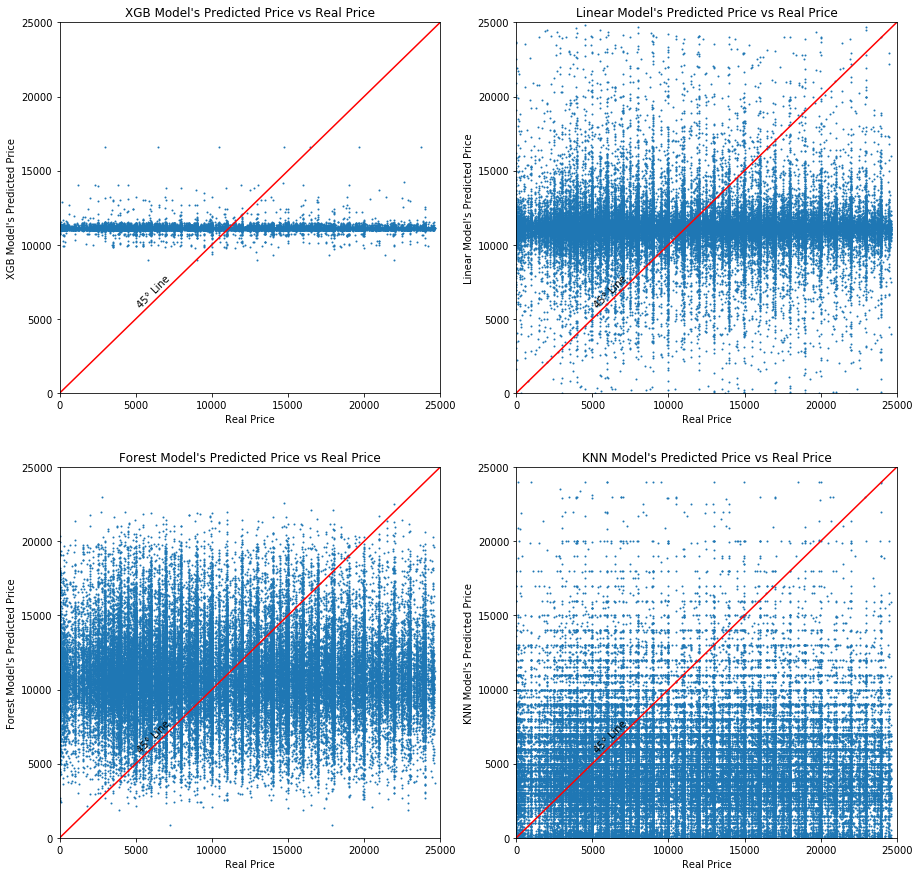

In [95]:
figNum = 0
predicted = [xgb_model_preds, lin_model_preds, forest_model_preds, knn_model_preds]
name = ["XGB", "Linear", "Forest", "KNN"]
degree_sign= u'\N{DEGREE SIGN}'

fig, axs = plt.subplots(nrows=2, ncols=2, figsize=(15,15))
for row in axs:
    for ax in row:
        pred = predicted[figNum]
        model = name[figNum]
        figTitle = model + " Model"
        
        ax.scatter(x=y_valid, y=pred, s=1)
        ax.set_xlim(0,25000)
        ax.set_ylim(0,25000)
        ax.set_xlabel("Real Price")
        ax.set_ylabel("{} Model's Predicted Price".format(model))
        
        ax.set_title("{}'s Predicted Price vs Real Price".format(figTitle))
        x = np.linspace(*ax.get_xlim())
        ax.plot(x, x, color="red")
        
        trans = ax.transAxes
        ax.text(0.2,0.23,"45{} Line".format(degree_sign) , rotation=45, transform = trans)
               
        figNum +=1
                
plt.show()

In the figure above, horizontal axis represents the real price while vertical axis is representing the predicted price of a given model. The red line is 45 degree line. Therefore, a point on the red line corresponds to an observation for which the model perfectly predicted its price. For a better visual comparison, the axes ranges are the same. Even though we believed that XG Boost performs the best, as we see above, most of the time it predicts the over all average. 

# 4.B. Part II

In the second part of the project, I will spend some more time on EDA and feature engineering. Moreover, I will optimize the models for a better performance. You can jump to the second part by clicking [here](https://github.com/suatakbulut/QuarantineProjects).